`📌 Problem Statement:

Predict whether an employee is likely to seek treatment for mental health issues, based on workplace environment, personal history, and company policies.`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("survey.csv")
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
df['treatment'].value_counts()

,count
treatment,
Yes,637
No,622


Text(0.5, 1.0, 'Target Value Distribution')

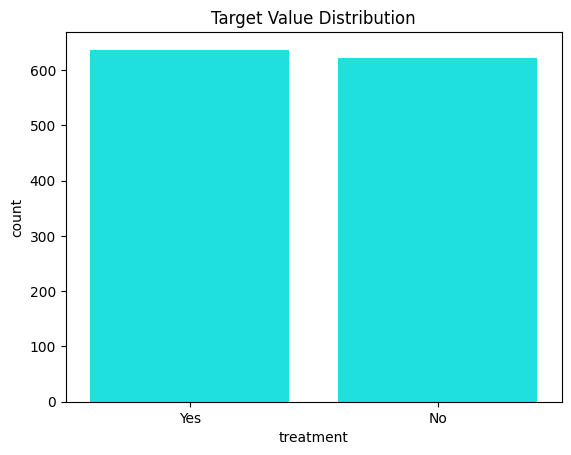

In [4]:
sns.countplot(data = df ,x = "treatment" ,color = "cyan")
plt.title("Target Value Distribution")

In [5]:
  df.isna().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,515
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0


In [6]:
# Cleaning the column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('[^a-z0-9_]', '', regex=True)
)

In [7]:
# Cleaning the Gender
def clean_gender(value):
    value = str(value).strip().lower()
    male_terms = ['male', 'm', 'man', 'cis male', 'msle', 'mail', 'mal', 'make', 'male-ish']
    female_terms = ['female', 'f', 'woman', 'cis female', 'femake', 'femail', 'female-ish']

    if value in male_terms:
        return 'male'
    elif value in female_terms:
        return 'female'
    else:
        return 'other'

df['gender'] = df['gender'].apply(clean_gender)

In [8]:
# Binary Encoding (Yes/No → 1/0)
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['self_employed', 'family_history', 'remote_work', 'tech_company', 'treatment']
for col in binary_cols:
    df[col] = df[col].map(binary_map)
    df[col] = df[col].fillna(0)  # Assuming No if missing (industry simplification)

In [9]:
# Ordinal Encoding - Interfernce Level
interfere_map = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3}
df['work_interfere'] = df['work_interfere'].map(interfere_map)
df['work_interfere'] = df['work_interfere'].fillna(df['work_interfere'].median())


In [10]:
# Encoding the Employee Range -> Ordinal
employee_order = {
    '1-5': 1, '6-25': 2, '26-100': 3, '100-500': 4, '500-1000': 5, 'More than 1000': 6 }
df['no_employees'] = df['no_employees'].map(employee_order)

In [11]:
# 🎯 STEP 6: HANDLE MULTI-CHOICE CATEGORICAL COLUMN
multi_cat_cols = ['benefits', 'care_options', 'wellness_program', 'seek_help',
                  'anonymity', 'leave', 'mental_health_consequence',
                  'phys_health_consequence', 'coworkers', 'supervisor']

In [12]:
# Clean values and group into Yes/No/Unknown
for col in multi_cat_cols:
    df[col] = df[col].fillna('Unknown')
    df[col] = df[col].apply(lambda x: 'Yes' if 'yes' in x.lower() else
                                      ('No' if 'no' in x.lower() else 'Unknown'))

In [13]:
# One-hot encode
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [14]:
# 🧽 STEP 7: CLEANUP AND FINAL TOUCHES
df['gender'] = df['gender'].map({'male': 0, 'female': 1, 'other': 2})

In [15]:
# Drop noisy / ID columns
drop_cols = ['comments', 'state', 'country', 'timestamp']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [16]:
# Remove rows with missing 'age' or extreme outliers
df = df[(df['age'] > 10) & (df['age'] < 100)]

In [17]:
print(f"✅ Final dataset shape: {df.shape}")
print(df.dtypes.head(10))
df.head()

✅ Final dataset shape: (1252, 27)
age                          int64
gender                       int64
self_employed              float64
family_history               int64
treatment                    int64
work_interfere             float64
no_employees                 int64
remote_work                  int64
tech_company                 int64
mental_health_interview     object
dtype: object


,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,mental_health_interview,...,anonymity_Yes,leave_Unknown,mental_health_consequence_Unknown,mental_health_consequence_Yes,phys_health_consequence_Unknown,phys_health_consequence_Yes,coworkers_Unknown,coworkers_Yes,supervisor_Unknown,supervisor_Yes
0,37,1,0.0,0,1,3.0,2,0,1,No,...,True,True,False,False,False,False,True,False,False,True
1,44,0,0.0,0,0,1.0,6,0,0,No,...,False,False,True,False,False,False,False,False,False,False
2,32,0,0.0,0,0,1.0,2,0,1,Yes,...,False,True,False,False,False,False,False,True,False,True
3,31,0,0.0,1,1,3.0,3,0,1,Maybe,...,False,True,False,True,False,True,True,False,False,False
4,31,0,0.0,0,0,0.0,4,1,1,Yes,...,False,False,False,False,False,False,True,False,False,True


In [18]:
X = df.drop('treatment' , axis=1)
y = df['treatment']

In [19]:
  X.select_dtypes(include='object').columns.tolist()

['mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence']

In [20]:
ordinal_map = {
    'No': 0,
    'Don\'t know': 1,
    'Maybe': 1,
    'Yes': 2
}

# Map ordinal scale where applicable
X['mental_health_interview'] = X['mental_health_interview'].map(ordinal_map)
X['phys_health_interview'] = X['phys_health_interview'].map(ordinal_map)

mental_physical_map = {
    'No': 0,
    'Don\'t know': 1,
    'Yes': 2
}
X['mental_vs_physical'] = X['mental_vs_physical'].map(mental_physical_map)

# Binary map
X['obs_consequence'] = X['obs_consequence'].map({'Yes': 1, 'No': 0})

# Final fill for any NaNs (just in case)
X = X.fillna(0)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix , roc_auc_score , roc_curve

In [22]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42 , stratify = y)

In [23]:
model = LogisticRegression(max_iter=1000 , random_state=42)
model.fit(X_train , y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [24]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [25]:
# 5. Evaluation Report
print("\n Classification Report (Baseline):\n")
print(classification_report(y_test, y_pred))


 Classification Report (Baseline):

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       124
           1       0.77      0.76      0.77       127

    accuracy                           0.76       251
   macro avg       0.76      0.76      0.76       251
weighted avg       0.76      0.76      0.76       251



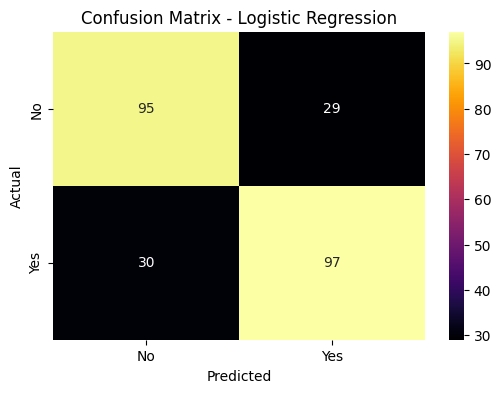

In [26]:
# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [27]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test , y_proba)
print(f"ROC-AUC score: {roc_auc:.4f}")

ROC-AUC score: 0.8242


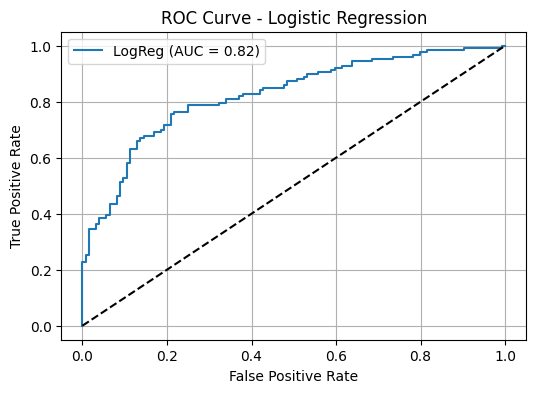

In [28]:
# Plotting the ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train , y_train)

RandomForestClassifier(random_state=42)

In [30]:
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:,1]

In [31]:
print(f"Classification Report - RandomForest :\n")
print(classification_report(y_test , rf_pred))

Classification Report - RandomForest :

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       124
           1       0.77      0.77      0.77       127

    accuracy                           0.77       251
   macro avg       0.77      0.77      0.77       251
weighted avg       0.77      0.77      0.77       251



In [32]:
rf_auc = roc_auc_score(y_test, rf_proba)
print(f"ROC-AUC Score (Random Forest): {rf_auc:.4f}")

ROC-AUC Score (Random Forest): 0.8426


## XGBoost

In [33]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [34]:
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:,1]

In [35]:
print("Classification Report - XGBoost:\n")
print(classification_report(y_test , xgb_pred))

Classification Report - XGBoost:

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       124
           1       0.74      0.71      0.73       127

    accuracy                           0.73       251
   macro avg       0.73      0.73      0.73       251
weighted avg       0.73      0.73      0.73       251



In [36]:
xgb_auc = roc_auc_score(y_test, xgb_proba)
print(f"🔍 ROC-AUC Score (XGBoost): {xgb_auc:.4f}")

🔍 ROC-AUC Score (XGBoost): 0.8186


<ipython-input-37-1395ae9cc2d1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_scores, palette='viridis')


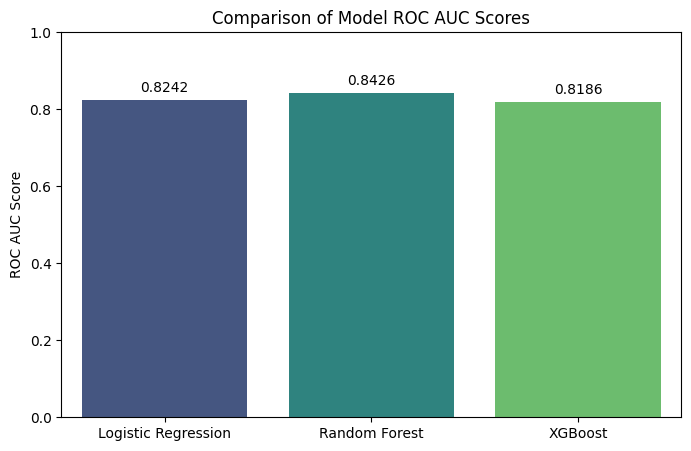

In [37]:

# 2. Bar Chart of AUC Scores
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores = [roc_auc, rf_auc, xgb_auc]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=auc_scores, palette='viridis')

plt.ylabel('ROC AUC Score')
plt.title('Comparison of Model ROC AUC Scores')
plt.ylim(0, 1) # AUC scores are between 0 and 1
for i, score in enumerate(auc_scores):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center') # Add score values above bars

plt.show()

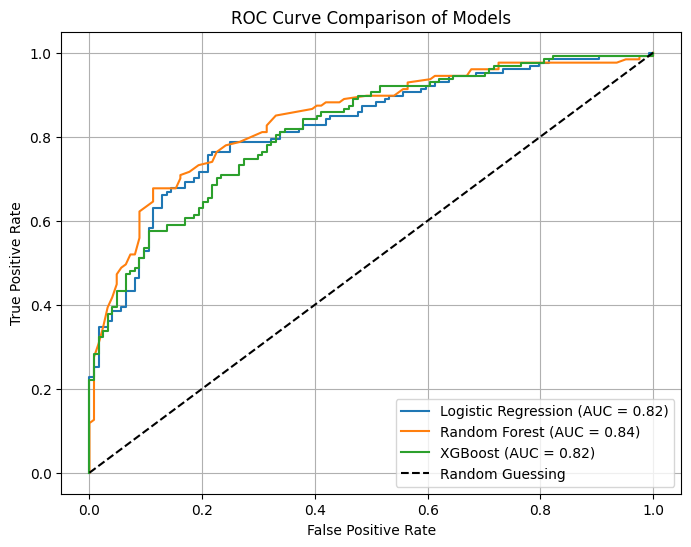

In [38]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)

# 1. Combined ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing') # Diagonal line for reference

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Hyperparameter

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [40]:
grid_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state =42),
    param_grid = param_grid ,
    cv = 5 ,
    n_jobs = -1 ,
    scoring = 'f1',
    verbose = 1
)

grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [41]:
best_rf = grid_search.best_estimator_

#Predictions
best_pred = best_rf.predict(X_test)
best_proba = best_rf.predict_proba(X_test)[:,1]

#Reporting
print("\n Best Parameters Found:")
print(grid_search.best_params_)

print("\n Classification Report (Tuned RF):")
print(classification_report(y_test, best_pred))


 Best Parameters Found:
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

 Classification Report (Tuned RF):
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       124
           1       0.80      0.78      0.79       127

    accuracy                           0.79       251
   macro avg       0.79      0.79      0.79       251
weighted avg       0.79      0.79      0.79       251



In [42]:
#ROC-AUC
best_auc = roc_auc_score(y_test , best_proba)
print(f"Tuned Random Forest ROC-AUC: {best_auc:.4f}")

Tuned Random Forest ROC-AUC: 0.8508


In [43]:
from sklearn.metrics import f1_score
# Performance table
model_scores = {
    'Model': ['Logistic Regression', 'Random Forest (Default)', 'Random Forest (Tuned)', 'XGBoost'],
    'F1 Score': [
        f1_score(y_test, y_pred),
        f1_score(y_test, rf_pred),
        f1_score(y_test, best_pred),
        f1_score(y_test, xgb_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba),
        roc_auc_score(y_test, rf_proba),
        roc_auc_score(y_test, best_proba),
        roc_auc_score(y_test, xgb_proba)
    ]
}

performance_df = pd.DataFrame(model_scores)
performance_df.sort_values(by='F1 Score', ascending=False, inplace=True)
performance_df.reset_index(drop=True, inplace=True)
performance_df

,Model,F1 Score,ROC-AUC
0,Random Forest (Tuned),0.792000,0.850838
1,Random Forest (Default),0.771654,0.842647
2,Logistic Regression,0.766798,0.824168
3,XGBoost,0.725806,0.818580


<ipython-input-44-065216da346e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=performance_df, palette='viridis')


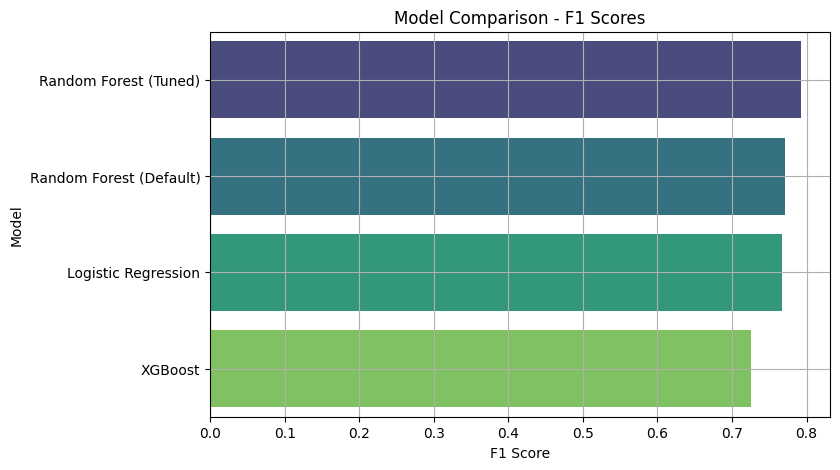

In [44]:
# Plot F1 Scores
plt.figure(figsize=(8, 5))
sns.barplot(x='F1 Score', y='Model', data=performance_df, palette='viridis')
plt.title('Model Comparison - F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.grid(True)
plt.show()

# Saving the model

In [45]:
import os

os.makedirs('model' , exist_ok=True)

In [48]:
import joblib

# Save the best model (Random Forest)
joblib.dump(best_rf, 'model/random_forest_model.pkl')

# Save the column names used during training
joblib.dump(X_train.columns.tolist(), 'model/feature_columns.pkl')

['model/feature_columns.pkl']